# BatchStudy

In this notebook, we explain how different models, experiments, chemistries, etc. can be compared with each other using the `BatchStudy` class.

## Comparing model
We start by creating a simple script to compare `SPM`, `SPMe` and `DFN` model with the default parameters.

In [1]:
# %pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm

dfn = pybamm.lithium_ion.DFN()
spm = pybamm.lithium_ion.SPM()
spme = pybamm.lithium_ion.SPMe()

models = {
    "dfn": dfn,
    "spm": spm,
    "spme": spme,
}

batch_study = pybamm.BatchStudy(models=models)
batch_study.solve([0, 3600])
batch_study.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [2]:
chen2020 = pybamm.parameter_sets.Chen2020
parameter_values = {"Chen2020": pybamm.ParameterValues(chemistry=chen2020)}

batch_study = pybamm.BatchStudy(models=models, parameter_values=parameter_values, permutations=True)
batch_study.solve([0, 3600])
batch_study.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3566.800904290021, step=35.66800904290021), …

In [3]:
model = {"spme": spme}

parameter_values = {
    "Chen2020_1": pybamm.ParameterValues(chemistry=chen2020),
    "Chen2020_2": pybamm.ParameterValues(chemistry=chen2020),
    "Chen2020_3": pybamm.ParameterValues(chemistry=chen2020),
}

current_values = [4.5, 4.75, 5]

for k, v, current_value in zip(parameter_values.keys(), parameter_values.values(), current_values):
    v["Current function [A]"] = current_value 

batch_study = pybamm.BatchStudy(models=model, parameter_values=parameter_values, permutations=True)
batch_study.solve([0, 3600])

labels = [f"Current function [A]: {current}" for current in current_values]
batch_study.plot(labels=labels)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [6]:
pybamm.set_logging_level("NOTICE")

cccv = pybamm.Experiment(
    [
        ("Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour")
    ]
    * 10,
)

mohtat2020 = pybamm.parameter_sets.Mohtat2020
parameter_values = {
    "Mohtat2020_1": pybamm.ParameterValues(chemistry=mohtat2020),
    "Mohtat2020_2": pybamm.ParameterValues(chemistry=mohtat2020),
    "Mohtat2020_3": pybamm.ParameterValues(chemistry=mohtat2020),
}

sei_kin_rate_consts = [2.0e-4, 2.7e-4, 3.4e-4]

for k, v, sei_kin_rate_const in zip(parameter_values.keys(), parameter_values.values(), current_values):
    v.update(
        {
            "Inner SEI open-circuit potential [V]": sei_kin_rate_const
        },
    )

model = {"spm": pybamm.lithium_ion.SPM({"SEI": "electron-migration limited"})}

experiment = {
    "cccv": cccv
}

batch_study = pybamm.BatchStudy(models=model, experiments=experiment, parameter_values=parameter_values, permutations=True)
batch_study.solve(initial_soc=1)
batch_study.plot()


2021-10-14 22:21:04,396 - [NOTICE] simulation.solve(809): Cycle 1/10 (43.187 ms elapsed) --------------------
2021-10-14 22:21:04,397 - [NOTICE] simulation.solve(843): Cycle 1/10, step 1/5: Discharge at C/10 for 10 hours or until 3.3 V
2021-10-14 22:21:04,723 - [NOTICE] simulation.solve(843): Cycle 1/10, step 2/5: Rest for 1 hour
2021-10-14 22:21:04,780 - [NOTICE] simulation.solve(843): Cycle 1/10, step 3/5: Charge at 1 A until 4.1 V
2021-10-14 22:21:04,948 - [NOTICE] simulation.solve(843): Cycle 1/10, step 4/5: Hold at 4.1 V until 50 mA
2021-10-14 22:21:05,025 - [NOTICE] simulation.solve(843): Cycle 1/10, step 5/5: Rest for 1 hour
2021-10-14 22:21:05,346 - [NOTICE] simulation.solve(809): Cycle 2/10 (993.816 ms elapsed) --------------------
2021-10-14 22:21:05,347 - [NOTICE] simulation.solve(843): Cycle 2/10, step 1/5: Discharge at C/10 for 10 hours or until 3.3 V
2021-10-14 22:21:05,622 - [NOTICE] simulation.solve(843): Cycle 2/10, step 2/5: Rest for 1 hour
2021-10-14 22:21:05,662 - [

interactive(children=(FloatSlider(value=0.0, description='t', max=154.5136974605279, step=1.545136974605279), …

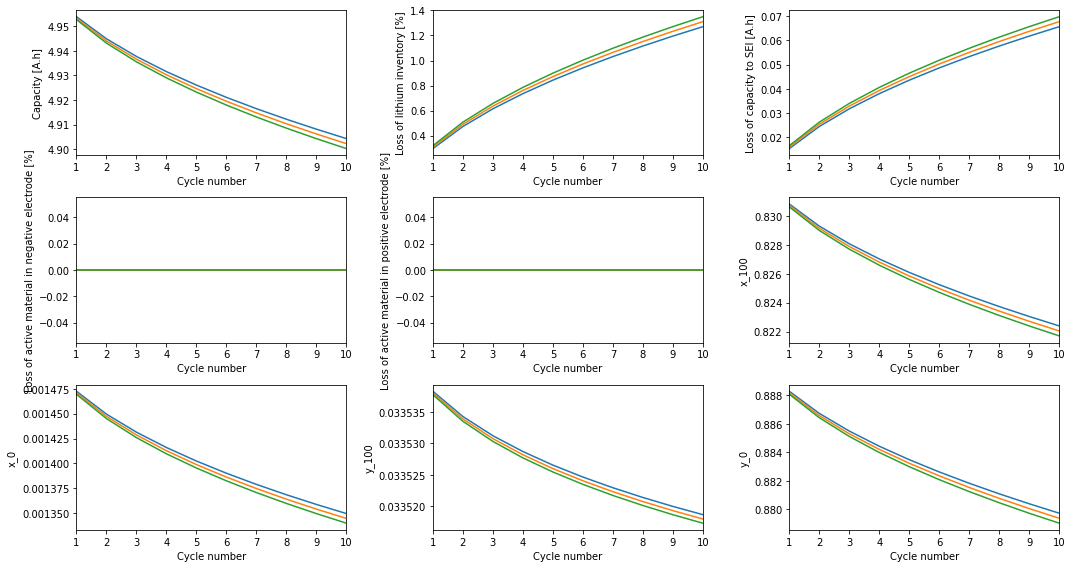

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [7]:
# print(batch_study.sims)
pybamm.plot_summary_variables([sim.solution for sim in batch_study.sims])